In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
sys.path.append(str(Path(os.getcwd()).parent))
from network import VisionTransformer, CNN
from runner import Runner
import glob

In [2]:
runners = {}

for file in ["../saved/cnn.pkl"] + sorted(glob.glob("../saved/vit_hiddensize64_numheads3_numblocks10_patchsize*.pkl")):
    model = file.split("/")[-1].split(".")[0]
    if "patchsize" in model:
        model = f"ViT (patch={model.split('patchsize')[-1]})"
        
    print("Model: ", model)

    runner = Runner.load(file)
    runners[model] = runner

Model:  cnn
Model:  ViT (patch=2)
Model:  ViT (patch=4)
Model:  ViT (patch=6)
Model:  ViT (patch=8)


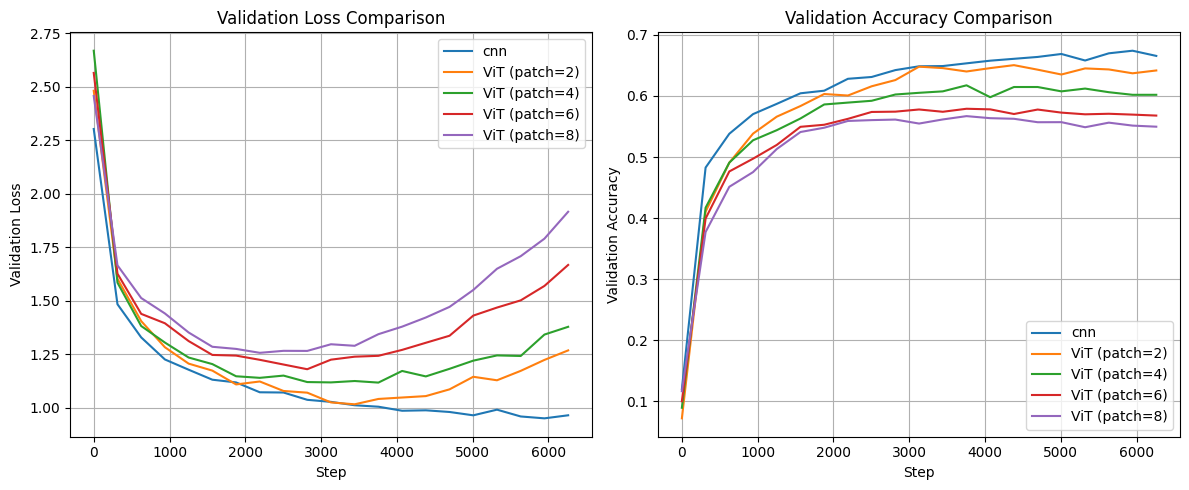

In [3]:
plt.figure(figsize=(12, 5))

# Plot validation loss
plt.subplot(1, 2, 1)
plt.grid(True)
for model_name, runner in runners.items():
    plt.plot(runner.metrics['val_step'], runner.metrics['val_loss'], label=model_name)
plt.xlabel('Step')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.grid(True)
for model_name, runner in runners.items():
    plt.plot(runner.metrics['val_step'], runner.metrics['val_accuracy'], label=model_name)
plt.xlabel('Step')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()

plt.tight_layout()
plt.savefig("../figures/model_comparison_curves.png")




Comparison: cnn - cnn
Loss difference: 0.0000 [0.0000, 0.0000]
Accuracy difference: 0.0000 [0.0000, 0.0000]

Comparison: ViT (patch=2) - cnn
Loss difference: 0.3105 [0.2754, 0.3442]
Accuracy difference: -0.0391 [-0.0494, -0.0283]

Comparison: ViT (patch=4) - cnn
Loss difference: 0.4317 [0.3961, 0.4682]
Accuracy difference: -0.0694 [-0.0801, -0.0588]

Comparison: ViT (patch=6) - cnn
Loss difference: 0.7137 [0.6706, 0.7540]
Accuracy difference: -0.1040 [-0.1149, -0.0937]

Comparison: ViT (patch=8) - cnn
Loss difference: 0.9103 [0.8655, 0.9565]
Accuracy difference: -0.1171 [-0.1281, -0.1066]


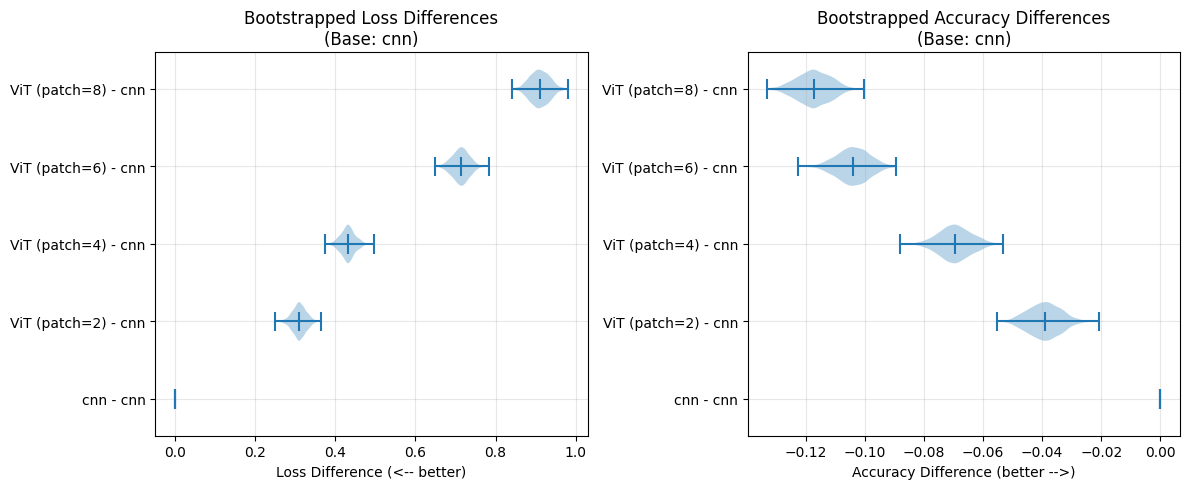

In [6]:
import pandas as pd
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_set = torchvision.datasets.CIFAR10(
    root='../data', 
    train=False,
    download=True, 
    transform=transform
)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)

def get_losses_and_accuracy(runner, test_loader):
    net = runner.model
    # Calculate loss for each example individually
    losses, accuracy = [], []
    net.eval() # Set model to evaluation mode
    criterion = nn.CrossEntropyLoss(reduction='none') # Use reduction='none' to get per-example loss

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(runner.device)
            y = y.to(runner.device)
            outputs = net(x)
            batch_losses = criterion(outputs, y)
            losses.extend(batch_losses.cpu().numpy())
            accuracy.extend((outputs.argmax(dim=1) == y).float().cpu().numpy())

    losses = np.array(losses)
    accuracy = np.array(accuracy)

    return losses, accuracy

# Get losses and accuracies for all models
model_metrics = {}
for model_name, runner in runners.items():
    losses, accuracy = get_losses_and_accuracy(runner, test_loader)
    model_metrics[model_name] = {
        'losses': losses,
        'accuracy': accuracy
    }

# Create DataFrames for losses and accuracies
loss_df = pd.DataFrame({model: metrics['losses'] for model, metrics in model_metrics.items()})
acc_df = pd.DataFrame({model: metrics['accuracy'] for model, metrics in model_metrics.items()})

# Calculate differences from baseline model
base_model = list(runners.keys())[0]
for compare_model in list(runners.keys()):
    loss_df[f'{compare_model} - {base_model}'] = loss_df[compare_model] - loss_df[base_model]
    acc_df[f'{compare_model} - {base_model}'] = acc_df[compare_model] - acc_df[base_model]

# Bootstrap resampling
n_bootstrap = 1000
diff_cols = [col for col in loss_df.columns if '-' in col]

loss_boots = []
acc_boots = []
for _ in range(n_bootstrap):
    # Resample with replacement
    idx = np.random.randint(0, len(loss_df), len(loss_df))
    loss_boots.append(loss_df.iloc[idx][diff_cols].mean())
    acc_boots.append(acc_df.iloc[idx][diff_cols].mean())

# Convert bootstrap results to DataFrames
loss_boots_df = pd.DataFrame(loss_boots)
acc_boots_df = pd.DataFrame(acc_boots)

plt.figure(figsize=(12, 5))

# Plot loss differences
plt.subplot(1, 2, 1)
plt.violinplot([loss_boots_df[col] for col in loss_boots_df.columns], 
               showmeans=True, showextrema=True, vert=False)
plt.yticks(range(1, len(diff_cols) + 1), diff_cols)
plt.title(f'Bootstrapped Loss Differences\n(Base: {base_model})')
plt.xlabel('Loss Difference (<-- better)')
plt.grid(True, alpha=0.3)

# Plot accuracy differences  
plt.subplot(1, 2, 2)
plt.violinplot([acc_boots_df[col] for col in acc_boots_df.columns],
               showmeans=True, showextrema=True, vert=False)
plt.yticks(range(1, len(diff_cols) + 1), diff_cols)
plt.title(f'Bootstrapped Accuracy Differences\n(Base: {base_model})')
plt.xlabel('Accuracy Difference (better -->)')
plt.grid(True, alpha=0.3)

# Print confidence intervals
for col in diff_cols:
    print(f"\nComparison: {col}")
    loss_ci = np.percentile(loss_boots_df[col], [2.5, 97.5])
    acc_ci = np.percentile(acc_boots_df[col], [2.5, 97.5])
    print(f"Loss difference: {loss_boots_df[col].mean():.4f} [{loss_ci[0]:.4f}, {loss_ci[1]:.4f}]")
    print(f"Accuracy difference: {acc_boots_df[col].mean():.4f} [{acc_ci[0]:.4f}, {acc_ci[1]:.4f}]")

plt.tight_layout()
plt.savefig("../figures/model_comparison_bootstrap.png")
plt.show()

In [5]:
import pandas as pd
pd.DataFrame(
    {
        "model": [model for model in runners.keys()],
        "loss": [loss_df[model].mean() for model in runners.keys()],
        "accuracy": [acc_df[model].mean() for model in runners.keys()]
    }
).set_index("model")

,loss,accuracy
model,,
cnn,0.962457,0.6702
ViT (patch=2),1.272252,0.6311
ViT (patch=4),1.394385,0.6005
ViT (patch=6),1.674802,0.5663
ViT (patch=8),1.872196,0.5530
